In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score,accuracy_score, mean_squared_error, confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
warnings.filterwarnings("ignore")

In [2]:
#load data
data = 'data/FURNITURE_MODEL_2024.csv'
df = pd.read_csv(data, skiprows=0, skipfooter=0, engine='python')
df.head()
print(df.shape)

(195467, 558)


In [3]:
#Convert date columns into datetime format
df['ACCOUNT_OPEN_DATE'] = df['ACCOUNT_OPEN_DATE'].apply(lambda x: pd.to_datetime(x, format='%d%b%Y:%H:%M:%S'))
df['APPLICATION_DATE'] = df['APPLICATION_DATE'].apply(lambda x: pd.to_datetime(x, format='%d%b%Y:%H:%M:%S'))

In [4]:
#Split data into a train dataset for development and a holdout dataset for validation
train_start_date = '2021-07-01'
train_end_date = '2022-06-30'
df_train = df[(df['ACCOUNT_OPEN_DATE'] >= train_start_date) & (df['ACCOUNT_OPEN_DATE'] <= train_end_date)]
df_holdout = df[~(df['ACCOUNT_OPEN_DATE'] >= train_start_date) & (df['ACCOUNT_OPEN_DATE'] <= train_end_date)]

In [5]:
df_train

,PROG_SOL_NUMBER,VENDOR_ID,APPLICATION_DATE,ACCOUNT_OPEN_DATE,WEB_APPS,FRAUD_CHARGEOFF,PROG_SOL_NUMBER0,FILE_NAME,AMS3798,AMS3132,...,AMS3994,AMS3995,DATA_SOURCE_ID,RECORD_SEQ_NO,TWO_PLUS_EVER_6M,THREE_PLUS_EVER_6M,CHARGE_OFF_6M,TWO_PLUS_EVER_9M,THREE_PLUS_EVER_9M,CHARGE_OFF_9M
1,10619502805133,93,2018-03-01,2022-01-24,0,0,10619502805133,20220128_PROD_EFXDataAttributes.xml,NaN,11.0,...,0.0,0.0,1472314,14970045,0,0,0,0,0,0
52,10619503781960,93,2020-07-01,2021-07-11,0,0,10619503781960,20210713_PROD_EFXDataAttributes.xml,NaN,23.0,...,1429.0,4286.0,1430150,10585362,1,0,0,1,0,0
121,10619503837028,93,2020-08-01,2021-10-18,0,0,10619503837028,20211020_PROD_EFXDataAttributes.xml,NaN,NaN,...,2500.0,10000.0,1451580,12736251,0,0,0,0,0,0
139,10619503845534,93,2020-08-01,2021-07-07,0,0,10619503845534,20210708_PROD_EFXDataAttributes.xml,NaN,52.0,...,3333.0,6667.0,1429443,10469540,1,1,0,1,1,1
161,10619503856010,93,2020-08-01,2021-08-23,0,0,10619503856010,20210825_PROD_EFXDataAttributes.xml,NaN,41.0,...,0.0,0.0,1438552,11506297,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195442,13109500638048,12131,2022-06-01,2022-06-30,0,0,13109500638048,20220705_PROD_EFXDataAttributes.xml,NaN,32.0,...,3333.0,3333.0,1504688,18560690,0,0,0,0,0,0
195443,13109500638055,12131,2022-06-01,2022-06-30,0,0,13109500638055,20220709_PROD_EFXDataAttributes.xml,NaN,64.0,...,0.0,10000.0,1505553,18635900,0,0,0,0,0,0
195444,13109500638071,12131,2022-06-01,2022-06-30,0,0,13109500638071,20220702_PROD_EFXDataAttributes.xml,NaN,31.0,...,0.0,10000.0,1504035,18484134,0,0,0,1,0,0
195445,13109500638089,12131,2022-06-01,2022-06-30,0,0,13109500638089,20220712_PROD_EFXDataAttributes.xml,5973.0,NaN,...,1818.0,8182.0,1506267,18708155,0,0,0,0,0,0


In [6]:
df_holdout

,PROG_SOL_NUMBER,VENDOR_ID,APPLICATION_DATE,ACCOUNT_OPEN_DATE,WEB_APPS,FRAUD_CHARGEOFF,PROG_SOL_NUMBER0,FILE_NAME,AMS3798,AMS3132,...,AMS3994,AMS3995,DATA_SOURCE_ID,RECORD_SEQ_NO,TWO_PLUS_EVER_6M,THREE_PLUS_EVER_6M,CHARGE_OFF_6M,TWO_PLUS_EVER_9M,THREE_PLUS_EVER_9M,CHARGE_OFF_9M
0,10619502751261,93,2018-01-01,2021-06-07,1,0,10619502751261,20180128_PROD_EFXDataAttributes.xml,NaN,NaN,...,714.0,4286.0,1107140,2111174,0,0,0,0,0,0
2,10619503169505,93,2019-03-01,2021-02-03,1,0,10619503169505,20190325_PROD_EFXDataAttributes.xml,NaN,NaN,...,984.0,4590.0,1213997,2990387,1,1,0,1,1,1
3,10619503474509,93,2019-12-01,2021-04-01,1,0,10619503474509,20191216_PROD_EFXDataAttributes.xml,NaN,108.0,...,0.0,10000.0,1284472,5032014,0,0,0,0,0,0
4,10619503594611,93,2020-02-01,2021-01-27,0,0,10619503594611,20210128_PROD_EFXDataAttributes.xml,NaN,NaN,...,6667.0,10000.0,1388382,7708513,0,0,0,0,0,0
5,10619503611399,93,2020-03-01,2021-01-25,0,0,10619503611399,20210126_PROD_EFXDataAttributes.xml,NaN,NaN,...,0.0,5000.0,1387742,7683751,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195462,88889500501672,1800,2021-03-01,2021-03-17,0,0,88889500501672,20210317_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1400921,8105816,0,0,0,0,0,0
195463,88889500501706,1800,2021-03-01,2021-03-17,0,0,88889500501706,20210317_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1400921,8109730,0,0,0,0,0,0
195464,88889500501722,1800,2021-03-01,2021-03-18,0,0,88889500501722,20210318_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1401259,8121081,0,0,0,0,0,0
195465,88889500501748,1800,2021-03-01,2021-03-18,0,0,88889500501748,20210318_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1401259,8117529,0,0,0,0,0,0


In [7]:
####################  EDA  ####################

In [8]:
# check data type, shape and info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121783 entries, 1 to 195446
Columns: 558 entries, PROG_SOL_NUMBER to CHARGE_OFF_9M
dtypes: datetime64[ns](2), float64(538), int64(13), object(5)
memory usage: 519.4+ MB


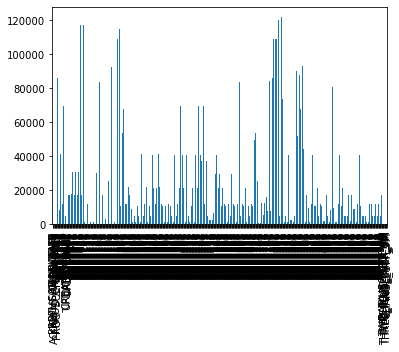

In [9]:
# check missing values
df_train.isna().sum().T.plot.bar()

In [10]:
# Calculate percent of missing rows for each column
df_train_missing = df_train.isna()
result = df_train_missing.sum()/len(df_train)

#{k:v for k,v in zip(result.index, list(result))}

In [11]:
# keep the column that has less than 10% of the row missing
na_threshold = 0.1
df_train_new = df_train.loc[:,result < na_threshold]
print('Original training set has {} of data.'.format(df_train.shape))
print('After dropping {} columns with more than {}% of missing data, we have {} of data.'.format((df_train.shape[1]-df_train_new.shape[1]), 100*(1-na_threshold), df_train_new.shape))

Original training set has (121783, 558) of data.
After dropping 236 columns with more than 90.0% of missing data, we have (121783, 322) of data.


In [12]:
# record dropped attributes 
df_dropped = df_train.loc[:,result >= na_threshold]
na_dropped_columns = pd.DataFrame(df_dropped.columns)
na_dropped_columns.rename(columns={0: 'original_cname'}, inplace=True)
na_dropped_columns

,original_cname
0,AMS3798
1,AMS3132
2,AMS3363
3,AMS3195
4,AMS3387
...,...
231,AMS3985
232,AMS3990
233,AMS3993
234,AMS3994


In [13]:
# load mapping table ams_column_mapping.csv
column_map = 'data/ams_column_mapping.csv'
df_column_map =  pd.read_csv(column_map, skiprows=0, skipfooter=0)
df_column_map.head()

,original_cname,mapped_cname
0,AMS3000,# Inq w/in 3 M
1,AMS3001,# Inq w/in 12 M
2,AMS3002,# Inq w/in 24 M
3,AMS3008,# Non-Util Inq w/in 1 Month
4,AMS3009,# Non-Util Inq w/in 3 M


In [14]:
# map dropped attributes to its mapped meaning based on Equifax file
ams_column_mapping_path = 'data/ams_column_mapping.csv'
ams_column_mapping_df = pd.read_csv(ams_column_mapping_path, skiprows=0, skipfooter=0, engine='python')
ams_column_mapping_df = ams_column_mapping_df.merge(na_dropped_columns, on=['original_cname'])
ams_column_mapping_df

,original_cname,mapped_cname
0,AMS3000,# Inq w/in 3 M
1,AMS3001,# Inq w/in 12 M
2,AMS3002,# Inq w/in 24 M
3,AMS3008,# Non-Util Inq w/in 1 Month
4,AMS3009,# Non-Util Inq w/in 3 M
...,...,...
231,AMS3985,% Dept Store Trades w/MajDerog Event w/in 24 M...
232,AMS3990,% Dept Store Trades w/Unpaid MajDerog Event w/...
233,AMS3993,% Inq w/in 3 M to Inq w/in 12 M
234,AMS3994,% Inq w/in 3 M to Inq w/in 24 M


In [15]:
# save dropped attributes for internal expert review
ams_column_mapping_df.to_excel('na_dropped_attributes.xlsx', sheet_name='na_rate_threshold-{}'.format(na_threshold), index=False)

In [16]:
# drop rows that still have missing values
df_train_new.dropna(axis=0, inplace=True)
print('After dropping {} rows with missing values, we have {} of data.'.format((df_train.shape[0]-df_train_new.shape[0]), df_train_new.shape))

After dropping 36043 rows with missing values, we have (85740, 322) of data.


In [17]:
# Find distribution of vendors in the dataset
df_train_new['VENDOR_ID'].value_counts(normalize=True)

9151     0.583753
93       0.092920
8635     0.060205
12131    0.052134
3672     0.040914
           ...   
11813    0.000012
11353    0.000012
12531    0.000012
7193     0.000012
11254    0.000012
Name: VENDOR_ID, Length: 94, dtype: float64

In [18]:
# map the column name
df_cmap = df_train_new.rename(columns=df_column_map.set_index('original_cname')['mapped_cname'].to_dict())
df_cmap.head()

,PROG_SOL_NUMBER,VENDOR_ID,APPLICATION_DATE,ACCOUNT_OPEN_DATE,WEB_APPS,FRAUD_CHARGEOFF,PROG_SOL_NUMBER0,FILE_NAME,T PD Inst Trades,# 3rd Party Collections,...,% Inst Trades w/Unpaid MajDerog Event w/in 24 M to Inst Trades,% Rev Trades w/Unpaid MajDerog Event w/in 24 M to Rev Trades,DATA_SOURCE_ID,RECORD_SEQ_NO,TWO_PLUS_EVER_6M,THREE_PLUS_EVER_6M,CHARGE_OFF_6M,TWO_PLUS_EVER_9M,THREE_PLUS_EVER_9M,CHARGE_OFF_9M
1,10619502805133,93,2018-03-01,2022-01-24,0,0,10619502805133,20220128_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1472314,14970045,0,0,0,0,0,0
52,10619503781960,93,2020-07-01,2021-07-11,0,0,10619503781960,20210713_PROD_EFXDataAttributes.xml,0.0,1.0,...,0.0,0.0,1430150,10585362,1,0,0,1,0,0
139,10619503845534,93,2020-08-01,2021-07-07,0,0,10619503845534,20210708_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1429443,10469540,1,1,0,1,1,1
269,10619503897287,93,2020-09-01,2021-07-25,0,0,10619503897287,20200905_PROD_EFXDataAttributes.xml,0.0,1.0,...,0.0,0.0,1350569,6557238,0,0,0,0,0,0
286,10619503900099,93,2020-09-01,2021-07-09,0,0,10619503900099,20210710_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1429629,10510934,0,0,0,0,0,0


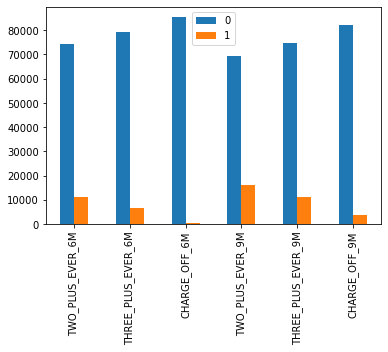

In [19]:
# check distribution of labelled variables
c_lst = ['TWO_PLUS_EVER_6M', 'THREE_PLUS_EVER_6M','CHARGE_OFF_6M', 'TWO_PLUS_EVER_9M', 'THREE_PLUS_EVER_9M','CHARGE_OFF_9M']
plt_df = df_cmap[c_lst]
plt_df.apply(pd.value_counts).T.plot.bar()

In [20]:
# exclude non-independent variables
non_ind_vars = ['PROG_SOL_NUMBER', 'VENDOR_ID', 'APPLICATION_DATE', 'ACCOUNT_OPEN_DATE', 'PROG_SOL_NUMBER0', 'FILE_NAME', 'DATA_SOURCE_ID', 'RECORD_SEQ_NO','CREATED_DATE', 'CREATED_BY', 'UPDATED_DATE', 'UPDATED_BY']
target_vars = ['TWO_PLUS_EVER_6M', 'THREE_PLUS_EVER_6M', 'CHARGE_OFF_6M', 'TWO_PLUS_EVER_9M', 'THREE_PLUS_EVER_9M', 'CHARGE_OFF_9M']
ind_var_df = df_train_new.drop(columns=non_ind_vars).drop(columns=target_vars)
ind_var_df

,WEB_APPS,FRAUD_CHARGEOFF,AMS3242,AMS3909,AMS3102,AMS3836,AMS3856,AMS3257,AMS3109,AMS3124,...,AMS3981,AMS3982,AMS3983,AMS3984,AMS3986,AMS3987,AMS3988,AMS3989,AMS3991,AMS3992
1,0,0,0.0,0.0,8.0,3200.0,6482.0,0.0,25.0,34.0,...,400.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0,0,0.0,1.0,20.0,7174.0,3574.0,0.0,46.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,0,0,0.0,0.0,10.0,8333.0,3069.0,0.0,18.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269,0,0,0.0,1.0,5.0,8571.0,8979.0,0.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,0,0,0.0,0.0,14.0,8400.0,7223.0,0.0,25.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195441,0,0,0.0,0.0,4.0,2000.0,2425.0,0.0,5.0,18.0,...,8000.0,2000.0,1667.0,0.0,0.0,2000.0,1667.0,0.0,0.0,2000.0
195443,0,0,0.0,0.0,2.0,1667.0,0.0,0.0,6.0,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195444,0,0,0.0,0.0,6.0,6667.0,4530.0,0.0,12.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195445,0,0,0.0,8.0,13.0,4286.0,2019.0,0.0,28.0,1.0,...,3929.0,3929.0,1607.0,4615.0,0.0,3214.0,1607.0,4615.0,0.0,3214.0


In [21]:
### Feature Selection

In [22]:
#create a correlation matrix over all independent variables
corr_df = ind_var_df.corr()
#fig, ax = plt.subplots(figsize=(24, 12))
#sns.heatmap(corr_df, annot=True, vmin=-1.0)
#plt.title('Correlation Heatmap')
#plt.show()

In [23]:
corr_df

,WEB_APPS,FRAUD_CHARGEOFF,AMS3242,AMS3909,AMS3102,AMS3836,AMS3856,AMS3257,AMS3109,AMS3124,...,AMS3981,AMS3982,AMS3983,AMS3984,AMS3986,AMS3987,AMS3988,AMS3989,AMS3991,AMS3992
WEB_APPS,1.000000,-0.016095,0.018473,0.065515,0.159317,0.002947,0.166464,0.028591,0.131009,-0.141714,...,0.121634,0.121325,0.052511,0.040865,0.016786,0.047574,0.055977,0.040782,0.018403,0.050442
FRAUD_CHARGEOFF,-0.016095,1.000000,-0.006212,-0.015664,0.008426,-0.011216,-0.033821,-0.007258,-0.001146,0.020850,...,-0.021544,-0.018932,-0.012259,-0.008932,-0.007522,-0.010568,-0.010853,-0.007767,-0.006623,-0.009462
AMS3242,0.018473,-0.006212,1.000000,0.043743,-0.020706,-0.032744,-0.003232,-0.014982,-0.021267,0.009478,...,0.054923,0.053642,0.052262,0.023709,0.109554,0.023226,0.058230,0.021797,0.124454,0.024218
AMS3909,0.065515,-0.015664,0.043743,1.000000,-0.036826,-0.088559,0.040883,-0.010038,-0.014260,-0.013088,...,0.240781,0.264594,0.050843,0.054713,0.005046,0.080956,0.056692,0.064552,0.002397,0.095716
AMS3102,0.159317,0.008426,-0.020706,-0.036826,1.000000,-0.201880,-0.057761,0.051926,0.846903,-0.212832,...,-0.037226,-0.041420,-0.021729,-0.005336,-0.016281,-0.024967,-0.020209,-0.007604,-0.014147,-0.025884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMS3987,0.047574,-0.010568,0.023226,0.080956,-0.024967,-0.254622,0.014630,0.003126,-0.028136,0.012283,...,0.478646,0.433405,0.769638,0.792060,0.127612,1.000000,0.687789,0.696524,0.130140,0.904235
AMS3988,0.055977,-0.010853,0.058230,0.056692,-0.020209,-0.221704,0.001427,-0.001891,-0.015010,-0.005846,...,0.334478,0.375688,0.929491,0.552445,0.457461,0.687789,1.000000,0.599830,0.512113,0.756847
AMS3989,0.040782,-0.007767,0.021797,0.064552,-0.007604,-0.206181,-0.002168,0.014305,0.001195,0.022499,...,0.329351,0.368019,0.566350,0.899052,0.114495,0.696524,0.599830,1.000000,0.120947,0.768574
AMS3991,0.018403,-0.006623,0.124454,0.002397,-0.014147,-0.075347,-0.012400,-0.013066,-0.013934,-0.014936,...,0.074740,0.083509,0.471402,0.115517,0.881570,0.130140,0.512113,0.120947,1.000000,0.136999


In [24]:
# Looking for variables with high correlation using just the upper triangle
upper_corr = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))
upper_corr

,WEB_APPS,FRAUD_CHARGEOFF,AMS3242,AMS3909,AMS3102,AMS3836,AMS3856,AMS3257,AMS3109,AMS3124,...,AMS3981,AMS3982,AMS3983,AMS3984,AMS3986,AMS3987,AMS3988,AMS3989,AMS3991,AMS3992
WEB_APPS,NaN,-0.016095,0.018473,0.065515,0.159317,0.002947,0.166464,0.028591,0.131009,-0.141714,...,0.121634,0.121325,0.052511,0.040865,0.016786,0.047574,0.055977,0.040782,0.018403,0.050442
FRAUD_CHARGEOFF,NaN,NaN,-0.006212,-0.015664,0.008426,-0.011216,-0.033821,-0.007258,-0.001146,0.020850,...,-0.021544,-0.018932,-0.012259,-0.008932,-0.007522,-0.010568,-0.010853,-0.007767,-0.006623,-0.009462
AMS3242,NaN,NaN,NaN,0.043743,-0.020706,-0.032744,-0.003232,-0.014982,-0.021267,0.009478,...,0.054923,0.053642,0.052262,0.023709,0.109554,0.023226,0.058230,0.021797,0.124454,0.024218
AMS3909,NaN,NaN,NaN,NaN,-0.036826,-0.088559,0.040883,-0.010038,-0.014260,-0.013088,...,0.240781,0.264594,0.050843,0.054713,0.005046,0.080956,0.056692,0.064552,0.002397,0.095716
AMS3102,NaN,NaN,NaN,NaN,NaN,-0.201880,-0.057761,0.051926,0.846903,-0.212832,...,-0.037226,-0.041420,-0.021729,-0.005336,-0.016281,-0.024967,-0.020209,-0.007604,-0.014147,-0.025884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMS3987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.687789,0.696524,0.130140,0.904235
AMS3988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.599830,0.512113,0.756847
AMS3989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.120947,0.768574
AMS3991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.136999


In [25]:
# set correlation threshold to remove variables
corr_threshold = 0.8
corr_to_drop = [col for col in upper_corr.columns if any(np.abs(upper_corr[col])>corr_threshold)]
print('We find {} variables that has correlation of {} or more with one or more other variables.'.format(len(corr_to_drop), corr_threshold))
print('They are:')
corr_to_drop

We find 172 variables that has correlation of 0.8 or more with one or more other variables.
They are:


['AMS3109',
 'AMS3104',
 'AMS3120',
 'AMS3134',
 'AMS3135',
 'AMS3137',
 'AMS3139',
 'AMS3148',
 'AMS3157',
 'AMS3178',
 'AMS3194',
 'AMS3224',
 'AMS3236',
 'AMS3237',
 'AMS3239',
 'AMS3246',
 'AMS3277',
 'AMS3297',
 'AMS3316',
 'AMS3327',
 'AMS3329',
 'AMS3330',
 'AMS3333',
 'AMS3336',
 'AMS3338',
 'AMS3340',
 'AMS3347',
 'AMS3349',
 'AMS3350',
 'AMS3352',
 'AMS3354',
 'AMS3355',
 'AMS3356',
 'AMS3358',
 'AMS3360',
 'AMS3366',
 'AMS3367',
 'AMS3368',
 'AMS3369',
 'AMS3370',
 'AMS3372',
 'AMS3374',
 'AMS3376',
 'AMS3386',
 'AMS3395',
 'AMS3404',
 'AMS3410',
 'AMS3415',
 'AMS3417',
 'AMS3424',
 'AMS3435',
 'AMS3448',
 'AMS3453',
 'AMS3471',
 'AMS3472',
 'AMS3474',
 'AMS3479',
 'AMS3480',
 'AMS3544',
 'AMS3555',
 'AMS3562',
 'AMS3573',
 'AMS3590',
 'AMS3601',
 'AMS3608',
 'AMS3612',
 'AMS3614',
 'AMS3616',
 'AMS3619',
 'AMS3623',
 'AMS3625',
 'AMS3627',
 'AMS3630',
 'AMS3634',
 'AMS3724',
 'AMS3746',
 'AMS3747',
 'AMS3748',
 'AMS3750',
 'AMS3751',
 'AMS3752',
 'AMS3754',
 'AMS3795',
 'AM

In [26]:
# create a look-up mechanism for checking correlations of those candidate variables to be dropped
corr_to_drop_lkp = {}
for var in corr_to_drop:
    var_corr = corr_df[var][np.abs(corr_df[var])>corr_threshold]
    var_over_corr = list(var_corr.index[var_corr.apply(pd.notnull)])
    var_corr_lkp = [corr_df[var][v] for v in var_over_corr]
    corr_to_drop_lkp[var] = list(zip(var_over_corr,var_corr_lkp))

In [27]:
corr_to_drop_lkp

{'AMS3109': [('AMS3102', 0.8469026602779645),
  ('AMS3109', 1.0),
  ('AMS3104', 0.8109198533655922),
  ('AMS3178', 0.8712662788017899),
  ('AMS3376', 0.9614676213109649),
  ('AMS3751', 0.8026456867549573),
  ('AMS3754', 0.8050240810006271),
  ('AMS3966', 0.8113180728400433),
  ('AMS3967', 0.9726203006331571)],
 'AMS3104': [('AMS3109', 0.8109198533655922),
  ('AMS3104', 1.0),
  ('AMS3178', 0.9284159470229107)],
 'AMS3120': [('AMS3111', 0.8704119043969146), ('AMS3120', 1.0)],
 'AMS3134': [('AMS3133', 0.8898554462026441),
  ('AMS3134', 1.0),
  ('AMS3194', 0.8392298796834204)],
 'AMS3135': [('AMS3133', 0.8331710772338674),
  ('AMS3135', 1.0),
  ('AMS3194', 0.8863080336139653)],
 'AMS3137': [('AMS3146', 0.8358419421771421),
  ('AMS3137', 1.0),
  ('AMS3148', 0.8871956831523031),
  ('AMS3329', 0.9869295055859102),
  ('AMS3336', 0.8298310455428186),
  ('AMS3338', 0.9926928531758004),
  ('AMS3347', 0.8295547779970568),
  ('AMS3471', 0.9234843564296543),
  ('AMS3472', 0.999133228139961),
  ('AMS

In [28]:
# find common variables, keep common variables. 
common_var, common_val = zip(*corr_to_drop_lkp[list(corr_to_drop_lkp.keys())[0]])
for var in corr_to_drop_lkp:
    corr_var_val = corr_to_drop_lkp[var]
    corr_var, corr_val = zip(*corr_var_val)
    common_var = list(set(common_var).intersection(set(corr_var)))
print('We find {} commonly correlated variables to be kept.'.format(len(common_var)))
print('They are:')
common_var

We find 0 commonly correlated variables to be kept.
They are:


[]

In [29]:
# find frequent variables, keep the most frequent variables
freq_var, freq_val = zip(*corr_to_drop_lkp[list(corr_to_drop_lkp.keys())[0]])
freq_var = list(freq_var)
for var in corr_to_drop_lkp:
    corr_var_val = corr_to_drop_lkp[var]
    corr_var, corr_val = zip(*corr_var_val)
    freq_var.extend(corr_var)
print('We find {} variables (with repeat) that are has correlation greater than {} to the {} candidate variables.'.format(len(freq_var), corr_threshold, len(corr_to_drop)))
freq_var_set = set(freq_var)
print('Among those {} variables (with repeat), there are {} unique variables.'.format(len(freq_var), len(freq_var_set)))
freq = {var:freq_var.count(var) for var in freq_var_set}
freq = {k: v for k, v in sorted(freq.items(), key=lambda item: -item[1])}
freq_threshold = 10
freq_to_keep = [k for k,v in freq.items() if v>=10]
print('We want to keep {} variables, which appears more than {} times.'.format(len(freq_to_keep),freq_threshold))
print('They are:')
freq_to_keep

We find 1365 variables (with repeat) that are has correlation greater than 0.8 to the 172 candidate variables.
Among those 1365 variables (with repeat), there are 230 unique variables.
We want to keep 55 variables, which appears more than 10 times.
They are:


['AMS3754',
 'AMS3751',
 'AMS3146',
 'AMS3336',
 'AMS3893',
 'AMS3937',
 'AMS3347',
 'AMS3471',
 'AMS3935',
 'AMS3885',
 'AMS3601',
 'AMS3932',
 'AMS3752',
 'AMS3338',
 'AMS3472',
 'AMS3747',
 'AMS3888',
 'AMS3329',
 'AMS3887',
 'AMS3886',
 'AMS3137',
 'AMS3933',
 'AMS3934',
 'AMS3330',
 'AMS3942',
 'AMS3873',
 'AMS3921',
 'AMS3139',
 'AMS3922',
 'AMS3889',
 'AMS3936',
 'AMS3340',
 'AMS3874',
 'AMS3920',
 'AMS3875',
 'AMS3748',
 'AMS3594',
 'AMS3870',
 'AMS3967',
 'AMS3376',
 'AMS3895',
 'AMS3360',
 'AMS3872',
 'AMS3943',
 'AMS3871',
 'AMS3983',
 'AMS3919',
 'AMS3966',
 'AMS3896',
 'AMS3592',
 'AMS3894',
 'AMS3918',
 'AMS3370',
 'AMS3327',
 'AMS3148']

In [30]:
print('{} variables to keep are from the original corr_to_drop variables, the rest comes from the correlated variables'.format(len(list(set(corr_to_drop).intersection(set(freq_to_keep))))))

52 variables to keep are from the original corr_to_drop variables, the rest comes from the correlated variables


In [31]:
corr_to_drop_final = [var for var in corr_to_drop if var not in common_var and var not in freq_to_keep]
print('Dropping {} variables based on correlation matrix.'.format(len(corr_to_drop_final)))

Dropping 120 variables based on correlation matrix.


In [32]:
df_train_corr = df_train_new.drop(columns=non_ind_vars).drop(columns=corr_to_drop_final)
print('Now we have {} of data.'.format(df_train_corr.shape))

Now we have (85740, 190) of data.


In [33]:
#Get X variables
X_train_corr = df_train_corr.drop(columns=target_vars)
#Get all 6 target variables
y1_var, y2_var, y3_var, y4_var, y5_var, y6_var = df_train_corr[target_vars].columns
y_vars = [y1_var, y2_var, y3_var, y4_var, y5_var, y6_var]
ys = {var:df_train_corr[var] for var in y_vars}

In [34]:
X_train_corr_impute = X_train_corr

In [35]:
feature_list = list(X_train_corr_impute.columns)
feature_list

['WEB_APPS',
 'FRAUD_CHARGEOFF',
 'AMS3242',
 'AMS3909',
 'AMS3102',
 'AMS3836',
 'AMS3856',
 'AMS3257',
 'AMS3124',
 'AMS3146',
 'AMS3100',
 'AMS3101',
 'AMS3105',
 'AMS3111',
 'AMS3113',
 'AMS3116',
 'AMS3122',
 'AMS3127',
 'AMS3133',
 'AMS3136',
 'AMS3137',
 'AMS3139',
 'AMS3142',
 'AMS3148',
 'AMS3159',
 'AMS3168',
 'AMS3175',
 'AMS3176',
 'AMS3177',
 'AMS3192',
 'AMS3193',
 'AMS3208',
 'AMS3215',
 'AMS3217',
 'AMS3235',
 'AMS3266',
 'AMS3268',
 'AMS3270',
 'AMS3273',
 'AMS3286',
 'AMS3288',
 'AMS3290',
 'AMS3293',
 'AMS3307',
 'AMS3309',
 'AMS3312',
 'AMS3318',
 'AMS3320',
 'AMS3323',
 'AMS3327',
 'AMS3329',
 'AMS3330',
 'AMS3336',
 'AMS3338',
 'AMS3340',
 'AMS3347',
 'AMS3360',
 'AMS3361',
 'AMS3362',
 'AMS3364',
 'AMS3370',
 'AMS3376',
 'AMS3379',
 'AMS3380',
 'AMS3383',
 'AMS3388',
 'AMS3389',
 'AMS3392',
 'AMS3397',
 'AMS3398',
 'AMS3401',
 'AMS3406',
 'AMS3407',
 'AMS3413',
 'AMS3420',
 'AMS3426',
 'AMS3428',
 'AMS3431',
 'AMS3437',
 'AMS3439',
 'AMS3442',
 'AMS3446',
 'AMS34

In [36]:
#Build a xgboost tuning pipeline, try run this without any other feature selection and data manipulation

def get_xgb_models(trees, depth, lr):

    models = dict()

    for n in trees:

        for d in depth:

            for l in lr:

                models[str(n)+'-'+str(d)+'-'+str(l)] = xgb.XGBClassifier(n_estimators=n, learning_rate=l, max_depth = d)

    return(models)

 

def train_test(X_train, y_train, X_test, y_test, model_xgb):

    model_xgb.fit(X_train, y_train)

    y_pred_probs_train = model_xgb.predict_proba(X_train)[:,1]

    y_pred_train = model_xgb.predict(X_train)

    auc_train = round(roc_auc_score(y_train, y_pred_probs_train), 3)

   

    y_pred_probs_val = model_xgb.predict_proba(X_test)[:,1]

    y_pred_val = model_xgb.predict(X_test)

    auc_val = round(roc_auc_score(y_test, y_pred_probs_val), 3)
    
    cm = confusion_matrix(y_test,y_pred_val)
    
    neg_accuracy = round(cm[1,1] / (cm[1,1] + cm[1,0]), 3)
    
    pos_accuracy = round(cm[0,0] / (cm[0,0] + cm[0,1]), 3)
    
    f1 = round(f1_score(y_test,y_pred_val), 3)

   

    e = num_features(model_xgb)[0]

   

    return(auc_train, auc_val, y_pred_probs_train, y_pred_probs_val, e, pos_accuracy, neg_accuracy, f1)

 

def get_results(trees, depth, lr, X_train, y_train, X_test, y_test):

    models = get_xgb_models(trees, depth, lr)

    res = pd.DataFrame(columns = ['Trees','Depth','Rate','Train AUC','Val AUC', 'num_vars', 'Pos Accuracy', 'Neg Accuracy', 'F1'])

    for name, model_xgb in models.items():

        a, b, c, d, e, f, g, h = train_test(X_train, y_train, X_test, y_test, model_xgb)

        new_row = {}

        new_row['Trees'] = name.split('-')[0]

        new_row['Depth'] = name.split('-')[1]

        new_row['Rate'] = name.split('-')[2]

        new_row['Train AUC'] = a

        new_row['Val AUC'] = b

        new_row['num_vars'] = e
        
        new_row['Pos Accuracy'] = f
        
        new_row['Neg Accuracy'] = g
        
        new_row['F1'] = h

        print(new_row)

        res = res.append(new_row, ignore_index = True)

    return(res)

 

 

def num_features(model_xgb):

    feature_important = model_xgb.get_booster().get_score(importance_type='total_gain')

    keys=list(feature_important.keys())

    values = list(feature_important.values())

    data=pd.DataFrame(data=values,index=keys,columns=['Score']).sort_values(by='Score', ascending=False)

    #top_20 = data.index[:20]

    top_vars = []

    #print(feature_important)

    for i in data.index:

        top_vars.append(i)

        #print(i)

    return(len(top_vars), top_vars)

In [37]:
#Split data into 70/30 sets
X = X_train_corr_impute
y = ys[y5_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [38]:
xgb_results = get_results([2,3,4,5,6,7,8,9,10,12,15,20], [ 2,3,4,5], [0.1], X_train, y_train, X_test, y_test )

{'Trees': '2', 'Depth': '2', 'Rate': '0.1', 'Train AUC': 0.632, 'Val AUC': 0.62, 'num_vars': 4, 'Pos Accuracy': 1.0, 'Neg Accuracy': 0.009, 'F1': 0.019}
{'Trees': '2', 'Depth': '3', 'Rate': '0.1', 'Train AUC': 0.656, 'Val AUC': 0.639, 'num_vars': 8, 'Pos Accuracy': 1.0, 'Neg Accuracy': 0.009, 'F1': 0.019}
{'Trees': '2', 'Depth': '4', 'Rate': '0.1', 'Train AUC': 0.676, 'Val AUC': 0.656, 'num_vars': 12, 'Pos Accuracy': 0.999, 'Neg Accuracy': 0.016, 'F1': 0.031}
{'Trees': '2', 'Depth': '5', 'Rate': '0.1', 'Train AUC': 0.69, 'Val AUC': 0.67, 'num_vars': 20, 'Pos Accuracy': 0.999, 'Neg Accuracy': 0.016, 'F1': 0.031}
{'Trees': '3', 'Depth': '2', 'Rate': '0.1', 'Train AUC': 0.636, 'Val AUC': 0.625, 'num_vars': 5, 'Pos Accuracy': 1.0, 'Neg Accuracy': 0.009, 'F1': 0.019}
{'Trees': '3', 'Depth': '3', 'Rate': '0.1', 'Train AUC': 0.665, 'Val AUC': 0.646, 'num_vars': 11, 'Pos Accuracy': 1.0, 'Neg Accuracy': 0.009, 'F1': 0.019}
{'Trees': '3', 'Depth': '4', 'Rate': '0.1', 'Train AUC': 0.683, 'Val AUC

In [39]:
xgb_results

,Trees,Depth,Rate,Train AUC,Val AUC,num_vars,Pos Accuracy,Neg Accuracy,F1
0,2,2,0.1,0.632,0.620,4,1.000,0.009,0.019
1,2,3,0.1,0.656,0.639,8,1.000,0.009,0.019
2,2,4,0.1,0.676,0.656,12,0.999,0.016,0.031
3,2,5,0.1,0.690,0.670,20,0.999,0.016,0.031
4,3,2,0.1,0.636,0.625,5,1.000,0.009,0.019
5,3,3,0.1,0.665,0.646,11,1.000,0.009,0.019
6,3,4,0.1,0.683,0.663,17,0.999,0.016,0.031
7,3,5,0.1,0.699,0.677,26,0.999,0.015,0.029
8,4,2,0.1,0.640,0.628,5,1.000,0.009,0.019
9,4,3,0.1,0.675,0.656,12,1.000,0.009,0.019


In [40]:
# save performance to an external file
xgb_results.to_excel('xgb_results.xlsx',index=False)

Mean cross-validation score: 0.87
K-fold CV average score: 0.87


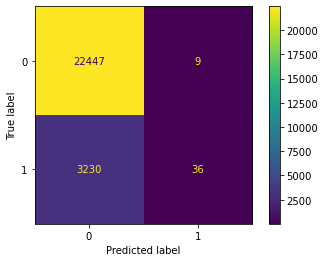

[[22447     9]
 [ 3230    36]]


In [41]:
# run the model with max validation auc and smaller number of variables

xgbc = XGBClassifier(n_estimators=20, learning_rate=0.1, max_depth = 4)
xgbc.fit(X_train, y_train)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
 
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

ypred = xgbc.predict(X_test)
cm = confusion_matrix(y_test,ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=xgbc.classes_)
disp.plot()

plt.show()
print(cm)

In [42]:
print('Although the auc is high, the sole purpose of predicting delinquency is undermined, as the model is predicting {} false positives and {} true negatives'.format(cm[1,0], cm[1,1]))
print('We are going to try further feature selection to simplify the model.')

Although the auc is high, the sole purpose of predicting delinquency is undermined, as the model is predicting 3230 false positives and 36 true negatives
We are going to try further feature selection to simplify the model.


In [43]:
# Run Lasso regression to further shrink feature size

In [44]:
#Build Lasso regressor
lasso_reg = LassoCV(cv=5, random_state=0, max_iter=1000)
lasso_reg.fit(X_train, y_train)

LassoCV(cv=5, random_state=0)

In [45]:
# Set best alpha
lasso_best = Lasso(alpha=lasso_reg.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.8756049484781347)

In [46]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 4.8
R squared test set 4.11


In [47]:
mean_squared_error(y_test, lasso_best.predict(X_test))

0.10629845984194136

In [48]:
lasso_coef_features = sorted(list(zip(lasso_best.coef_, X_train_corr)), key=lambda x:-np.abs(x[0]))
lasso_coef_features

[(-3.4476691511776273e-05, 'AMS3743'),
 (2.3971845658842636e-05, 'AMS3843'),
 (-1.2093665770240098e-05, 'AMS3869'),
 (1.0017979260648332e-05, 'AMS3856'),
 (-8.710762766587154e-06, 'AMS3864'),
 (8.041882311538094e-06, 'AMS3827'),
 (7.931364024703761e-06, 'AMS3829'),
 (-5.865850183770129e-06, 'AMS3837'),
 (4.660257128929235e-06, 'AMS3811'),
 (-4.647478127552295e-06, 'AMS3841'),
 (-4.294193490620133e-06, 'AMS3865'),
 (3.944391825414672e-06, 'AMS3845'),
 (-3.4916505540076868e-06, 'AMS3235'),
 (-3.3039841734959146e-06, 'AMS3862'),
 (-2.9085535925988673e-06, 'AMS3900'),
 (2.7611351731707946e-06, 'AMS3832'),
 (2.3949720444962484e-06, 'AMS3914'),
 (-2.1289006286380392e-06, 'AMS3839'),
 (-2.0376018301653635e-06, 'AMS3984'),
 (-1.9595341718471905e-06, 'AMS3840'),
 (1.888318841688868e-06, 'AMS3835'),
 (-1.2126814216229124e-06, 'AMS3838'),
 (1.0628069812381796e-06, 'AMS3833'),
 (1.0567484027217614e-06, 'AMS3986'),
 (9.93848264660731e-07, 'AMS3810'),
 (-9.092386885836714e-07, 'AMS3896'),
 (-4.81108

In [49]:
# selecting features with non-zero coefficient in lasso regression
lasso_features = [f for c,f in lasso_coef_features if np.abs(c)>0]
lasso_features

['AMS3743',
 'AMS3843',
 'AMS3869',
 'AMS3856',
 'AMS3864',
 'AMS3827',
 'AMS3829',
 'AMS3837',
 'AMS3811',
 'AMS3841',
 'AMS3865',
 'AMS3845',
 'AMS3235',
 'AMS3862',
 'AMS3900',
 'AMS3832',
 'AMS3914',
 'AMS3839',
 'AMS3984',
 'AMS3840',
 'AMS3835',
 'AMS3838',
 'AMS3833',
 'AMS3986',
 'AMS3810',
 'AMS3896',
 'AMS3895',
 'AMS3863',
 'AMS3831',
 'AMS3159',
 'AMS3168',
 'AMS3208',
 'AMS3242']

In [50]:
# Run XGBoost on the new data
X = X_train_corr_impute[lasso_features]
y = ys[y5_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [51]:
X_train

,AMS3743,AMS3843,AMS3869,AMS3856,AMS3864,AMS3827,AMS3829,AMS3837,AMS3811,AMS3841,...,AMS3986,AMS3810,AMS3896,AMS3895,AMS3863,AMS3831,AMS3159,AMS3168,AMS3208,AMS3242
124468,376.0,0.0,10000.0,9597.0,10000.0,7368.0,10000.0,3333.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10000.0,40087.0,19482.0,20300.0,0.0
40751,325.0,714.0,2000.0,4457.0,2857.0,1429.0,3333.0,0.0,5714.0,10000.0,...,5000.0,6667.0,10000.0,10000.0,9899.0,0.0,156.0,156.0,350.0,0.0
23443,356.0,0.0,5000.0,6280.0,5600.0,8400.0,2500.0,0.0,800.0,5000.0,...,0.0,5000.0,2500.0,2500.0,225.0,0.0,5499.0,157.0,250.0,175.0
131862,285.0,313.0,10000.0,7167.0,7188.0,5938.0,3333.0,1000.0,2500.0,1000.0,...,0.0,6667.0,500.0,500.0,0.0,5000.0,171244.0,3010.0,4200.0,8882.0
188915,112.0,6667.0,10000.0,1246.0,10000.0,3333.0,5000.0,5000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5000.0,162.0,162.0,1300.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123923,380.0,1200.0,10000.0,7212.0,8400.0,3600.0,6429.0,6000.0,2000.0,1333.0,...,0.0,3571.0,0.0,0.0,165.0,6923.0,31362.0,6141.0,8515.0,519.0
24890,192.0,1304.0,10000.0,1186.0,9130.0,8696.0,3333.0,2000.0,435.0,2000.0,...,500.0,3333.0,1667.0,1667.0,130.0,3333.0,33859.0,261.0,2200.0,447.0
23676,324.0,2222.0,10000.0,5677.0,7222.0,4444.0,2000.0,3333.0,3333.0,1667.0,...,0.0,6000.0,1667.0,1667.0,0.0,5000.0,24684.0,2867.0,5050.0,0.0
142628,254.0,400.0,10000.0,6249.0,8000.0,4800.0,4615.0,3333.0,2400.0,1111.0,...,0.0,4615.0,0.0,0.0,0.0,6000.0,90987.0,8499.0,13600.0,0.0


In [52]:
Counter(y_test)

Counter({0: 22456, 1: 3266})

In [53]:
xgb_results_lasso = get_results([2,3,4,5,6,7,8,9,10,12,15,20], [ 2,3,4,5], [0.1], X_train, y_train, X_test, y_test )

{'Trees': '2', 'Depth': '2', 'Rate': '0.1', 'Train AUC': 0.641, 'Val AUC': 0.627, 'num_vars': 3, 'Pos Accuracy': 1.0, 'Neg Accuracy': 0.0, 'F1': 0.0}
{'Trees': '2', 'Depth': '3', 'Rate': '0.1', 'Train AUC': 0.656, 'Val AUC': 0.641, 'num_vars': 4, 'Pos Accuracy': 1.0, 'Neg Accuracy': 0.0, 'F1': 0.0}
{'Trees': '2', 'Depth': '4', 'Rate': '0.1', 'Train AUC': 0.672, 'Val AUC': 0.656, 'num_vars': 9, 'Pos Accuracy': 1.0, 'Neg Accuracy': 0.0, 'F1': 0.0}
{'Trees': '2', 'Depth': '5', 'Rate': '0.1', 'Train AUC': 0.685, 'Val AUC': 0.663, 'num_vars': 17, 'Pos Accuracy': 0.999, 'Neg Accuracy': 0.004, 'F1': 0.007}
{'Trees': '3', 'Depth': '2', 'Rate': '0.1', 'Train AUC': 0.641, 'Val AUC': 0.627, 'num_vars': 3, 'Pos Accuracy': 1.0, 'Neg Accuracy': 0.0, 'F1': 0.0}
{'Trees': '3', 'Depth': '3', 'Rate': '0.1', 'Train AUC': 0.66, 'Val AUC': 0.643, 'num_vars': 4, 'Pos Accuracy': 1.0, 'Neg Accuracy': 0.0, 'F1': 0.0}
{'Trees': '3', 'Depth': '4', 'Rate': '0.1', 'Train AUC': 0.677, 'Val AUC': 0.66, 'num_vars': 1

In [54]:
xgb_results_lasso

,Trees,Depth,Rate,Train AUC,Val AUC,num_vars,Pos Accuracy,Neg Accuracy,F1
0,2,2,0.1,0.641,0.627,3,1.000,0.000,0.000
1,2,3,0.1,0.656,0.641,4,1.000,0.000,0.000
2,2,4,0.1,0.672,0.656,9,1.000,0.000,0.000
3,2,5,0.1,0.685,0.663,17,0.999,0.004,0.007
4,3,2,0.1,0.641,0.627,3,1.000,0.000,0.000
5,3,3,0.1,0.660,0.643,4,1.000,0.000,0.000
6,3,4,0.1,0.677,0.660,10,1.000,0.000,0.000
7,3,5,0.1,0.690,0.667,17,1.000,0.003,0.007
8,4,2,0.1,0.652,0.638,3,1.000,0.000,0.000
9,4,3,0.1,0.663,0.645,4,1.000,0.000,0.000


In [55]:
xgb_results_lasso.to_excel('xgb_results_lasso.xlsx',index=False)

Mean cross-validation score: 0.87
K-fold CV average score: 0.87


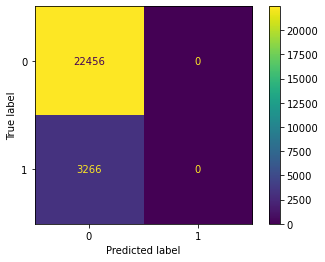

[[22456     0]
 [ 3266     0]]


In [56]:
# run the model with max validation auc and smaller number of variables

xgbc = XGBClassifier(n_estimators=20, learning_rate=0.1, max_depth = 4)
xgbc.fit(X_train, y_train)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
 
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

ypred = xgbc.predict(X_test)
cm = confusion_matrix(y_test,ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=xgbc.classes_)
disp.plot()

plt.show()
print(cm)

In [57]:
Counter(y)

Counter({0: 74635, 1: 11105})

In [58]:
print('The model is predicting {} false positives and {} true negatives'.format(cm[1,0], cm[1,1]))
print('We are going to deal with imbalanced label in the data.')

The model is predicting 3266 false positives and 0 true negatives
We are going to deal with imbalanced label in the data.


In [59]:
X_train_corr_impute[lasso_features]

,AMS3743,AMS3843,AMS3869,AMS3856,AMS3864,AMS3827,AMS3829,AMS3837,AMS3811,AMS3841,...,AMS3986,AMS3810,AMS3896,AMS3895,AMS3863,AMS3831,AMS3159,AMS3168,AMS3208,AMS3242
1,486.0,0.0,10000.0,6482.0,8205.0,2308.0,3200.0,3750.0,3077.0,5000.0,...,0.0,4800.0,0.0,0.0,0.0,3750.0,10773.0,10773.0,16620.0,0.0
52,374.0,484.0,10000.0,3574.0,10000.0,2581.0,4348.0,4444.0,2903.0,3611.0,...,0.0,3913.0,0.0,0.0,0.0,4848.0,113953.0,52655.0,147325.0,0.0
139,63.0,476.0,10000.0,3069.0,10000.0,1429.0,5556.0,4706.0,2857.0,3529.0,...,0.0,3333.0,0.0,0.0,0.0,5333.0,46856.0,9525.0,31040.0,0.0
269,367.0,1538.0,10000.0,8979.0,9231.0,4615.0,7143.0,5556.0,1538.0,1111.0,...,0.0,2857.0,0.0,0.0,0.0,8333.0,29814.0,7677.0,8550.0,0.0
286,335.0,714.0,10000.0,7223.0,10000.0,1071.0,5600.0,5652.0,3214.0,2609.0,...,0.0,3600.0,0.0,0.0,0.0,6190.0,16763.0,16046.0,22214.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195441,90.0,0.0,10000.0,2425.0,3333.0,1667.0,8000.0,10000.0,3333.0,0.0,...,0.0,4000.0,10000.0,10000.0,0.0,10000.0,97.0,97.0,400.0,0.0
195443,410.0,0.0,10000.0,0.0,10000.0,6471.0,3333.0,5000.0,588.0,0.0,...,0.0,1667.0,0.0,0.0,0.0,10000.0,0.0,0.0,28500.0,0.0
195444,304.0,0.0,10000.0,4530.0,8261.0,4783.0,5000.0,5556.0,1739.0,2222.0,...,0.0,3333.0,0.0,0.0,0.0,6250.0,42857.0,7465.0,16480.0,0.0
195445,394.0,893.0,7333.0,2019.0,7857.0,5000.0,4643.0,3750.0,2321.0,2500.0,...,0.0,4643.0,4737.0,4737.0,1057.0,5000.0,51818.0,1454.0,7200.0,0.0


In [60]:
Counter(ys[y5_var])

Counter({0: 74635, 1: 11105})

In [61]:
# The code below for SMOTE is referenced from machinelearningmastery.com
#URL: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [62]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
# define dataset
X = X_train_corr_impute[lasso_features]
y = ys[y5_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
# define pipeline
over = SMOTE(sampling_strategy=0.55)
under = RandomUnderSampler(sampling_strategy=0.99)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
print(X_train.shape)
counter = Counter(y_train)
print(counter)

(57685, 33)
Counter({0: 28987, 1: 28698})


In [63]:
xgb_results_lasso_SMOTE = get_results([2,3,4,5,6,7,8,9,10,12,15,20], [2,3,4,5], [0.1], X_train, y_train, X_test, y_test )

{'Trees': '2', 'Depth': '2', 'Rate': '0.1', 'Train AUC': 0.672, 'Val AUC': 0.598, 'num_vars': 4, 'Pos Accuracy': 0.662, 'Neg Accuracy': 0.498, 'F1': 0.26}
{'Trees': '2', 'Depth': '3', 'Rate': '0.1', 'Train AUC': 0.699, 'Val AUC': 0.622, 'num_vars': 7, 'Pos Accuracy': 0.547, 'Neg Accuracy': 0.609, 'F1': 0.258}
{'Trees': '2', 'Depth': '4', 'Rate': '0.1', 'Train AUC': 0.717, 'Val AUC': 0.626, 'num_vars': 10, 'Pos Accuracy': 0.548, 'Neg Accuracy': 0.655, 'F1': 0.275}
{'Trees': '2', 'Depth': '5', 'Rate': '0.1', 'Train AUC': 0.734, 'Val AUC': 0.635, 'num_vars': 18, 'Pos Accuracy': 0.603, 'Neg Accuracy': 0.592, 'F1': 0.274}
{'Trees': '3', 'Depth': '2', 'Rate': '0.1', 'Train AUC': 0.673, 'Val AUC': 0.6, 'num_vars': 4, 'Pos Accuracy': 0.662, 'Neg Accuracy': 0.498, 'F1': 0.26}
{'Trees': '3', 'Depth': '3', 'Rate': '0.1', 'Train AUC': 0.7, 'Val AUC': 0.617, 'num_vars': 8, 'Pos Accuracy': 0.533, 'Neg Accuracy': 0.624, 'F1': 0.258}
{'Trees': '3', 'Depth': '4', 'Rate': '0.1', 'Train AUC': 0.721, 'Val

In [64]:
xgb_results_lasso_SMOTE.to_excel('xgb_results_lasso_SMOTE.xlsx',index=False)

Mean cross-validation score: 0.66
K-fold CV average score: 0.66


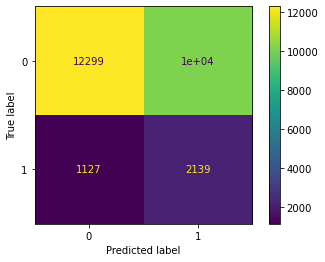

[[12299 10157]
 [ 1127  2139]]


In [65]:
# run the model with max validation auc, negative accuracy and smaller number of variables

xgbc = XGBClassifier(n_estimators=2, learning_rate=0.1, max_depth = 4)
xgbc.fit(X_train, y_train)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
 
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

ypred = xgbc.predict(X_test)
cm = confusion_matrix(y_test,ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=xgbc.classes_)
disp.plot()

plt.show()
print(cm)

In [66]:
Counter(y_test)

Counter({0: 22456, 1: 3266})

In [67]:
#Validating the model with holdout dataset
df_holdout

,PROG_SOL_NUMBER,VENDOR_ID,APPLICATION_DATE,ACCOUNT_OPEN_DATE,WEB_APPS,FRAUD_CHARGEOFF,PROG_SOL_NUMBER0,FILE_NAME,AMS3798,AMS3132,...,AMS3994,AMS3995,DATA_SOURCE_ID,RECORD_SEQ_NO,TWO_PLUS_EVER_6M,THREE_PLUS_EVER_6M,CHARGE_OFF_6M,TWO_PLUS_EVER_9M,THREE_PLUS_EVER_9M,CHARGE_OFF_9M
0,10619502751261,93,2018-01-01,2021-06-07,1,0,10619502751261,20180128_PROD_EFXDataAttributes.xml,NaN,NaN,...,714.0,4286.0,1107140,2111174,0,0,0,0,0,0
2,10619503169505,93,2019-03-01,2021-02-03,1,0,10619503169505,20190325_PROD_EFXDataAttributes.xml,NaN,NaN,...,984.0,4590.0,1213997,2990387,1,1,0,1,1,1
3,10619503474509,93,2019-12-01,2021-04-01,1,0,10619503474509,20191216_PROD_EFXDataAttributes.xml,NaN,108.0,...,0.0,10000.0,1284472,5032014,0,0,0,0,0,0
4,10619503594611,93,2020-02-01,2021-01-27,0,0,10619503594611,20210128_PROD_EFXDataAttributes.xml,NaN,NaN,...,6667.0,10000.0,1388382,7708513,0,0,0,0,0,0
5,10619503611399,93,2020-03-01,2021-01-25,0,0,10619503611399,20210126_PROD_EFXDataAttributes.xml,NaN,NaN,...,0.0,5000.0,1387742,7683751,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195462,88889500501672,1800,2021-03-01,2021-03-17,0,0,88889500501672,20210317_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1400921,8105816,0,0,0,0,0,0
195463,88889500501706,1800,2021-03-01,2021-03-17,0,0,88889500501706,20210317_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1400921,8109730,0,0,0,0,0,0
195464,88889500501722,1800,2021-03-01,2021-03-18,0,0,88889500501722,20210318_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1401259,8121081,0,0,0,0,0,0
195465,88889500501748,1800,2021-03-01,2021-03-18,0,0,88889500501748,20210318_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1401259,8117529,0,0,0,0,0,0


In [68]:
all_vars = lasso_features.copy()
all_vars.extend(target_vars)
all_vars

['AMS3743',
 'AMS3843',
 'AMS3869',
 'AMS3856',
 'AMS3864',
 'AMS3827',
 'AMS3829',
 'AMS3837',
 'AMS3811',
 'AMS3841',
 'AMS3865',
 'AMS3845',
 'AMS3235',
 'AMS3862',
 'AMS3900',
 'AMS3832',
 'AMS3914',
 'AMS3839',
 'AMS3984',
 'AMS3840',
 'AMS3835',
 'AMS3838',
 'AMS3833',
 'AMS3986',
 'AMS3810',
 'AMS3896',
 'AMS3895',
 'AMS3863',
 'AMS3831',
 'AMS3159',
 'AMS3168',
 'AMS3208',
 'AMS3242',
 'TWO_PLUS_EVER_6M',
 'THREE_PLUS_EVER_6M',
 'CHARGE_OFF_6M',
 'TWO_PLUS_EVER_9M',
 'THREE_PLUS_EVER_9M',
 'CHARGE_OFF_9M']

In [69]:
df_holdout_final = df_holdout[all_vars]
df_holdout_final.shape

(73684, 39)

In [70]:
df_holdout_final.dropna(axis=0, inplace=True)
df_holdout_final.shape

(57188, 39)

In [71]:
#Get X variables
X_holdout = df_holdout_final[lasso_features]
#Get all 6 target variables
y1_var, y2_var, y3_var, y4_var, y5_var, y6_var = df_holdout_final[target_vars].columns
y_vars = [y1_var, y2_var, y3_var, y4_var, y5_var, y6_var]
ys_holdout = {var:df_holdout_final[var] for var in y_vars}

In [72]:
y_holdout = ys_holdout[y5_var]
y_holdout

0         0
2         1
3         0
4         0
5         0
         ..
187769    0
187770    0
187772    0
187773    0
187774    0
Name: THREE_PLUS_EVER_9M, Length: 57188, dtype: int64

In [73]:
Counter(y_holdout)

Counter({0: 50869, 1: 6319})

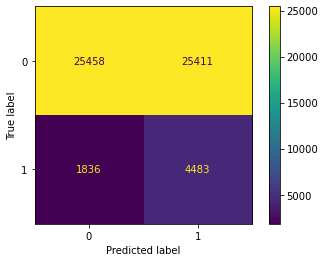

[[25458 25411]
 [ 1836  4483]]
0.709447697420478


In [74]:
ypred = xgbc.predict(X_holdout)
cm = confusion_matrix(y_holdout,ypred)
neg_accuracy = cm[1,1] / (cm[1,1] + cm[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=xgbc.classes_)
disp.plot()

plt.show()
print(cm)
print(neg_accuracy)

In [75]:
accuracy_score(y_holdout,ypred)

0.5235538924249843

In [76]:
f1_score(y_holdout,ypred)

0.24759064424377988

In [77]:
y_pred_probs_val = xgbc.predict_proba(X_test)[:,1]
auc_val = round(roc_auc_score(y_test, y_pred_probs_val), 3)
auc_val

0.626

In [78]:
# run the model with max validation auc, negative accuracy and smaller number of variables

xgbc = XGBClassifier(n_estimators=9, learning_rate=0.1, max_depth = 4)
xgbc.fit(X_train, y_train)
features = num_features(xgbc)[1]

In [79]:
num_features(xgbc)[0]

18

In [80]:
features

['AMS3208',
 'AMS3843',
 'AMS3845',
 'AMS3856',
 'AMS3864',
 'AMS3743',
 'AMS3865',
 'AMS3900',
 'AMS3832',
 'AMS3829',
 'AMS3831',
 'AMS3863',
 'AMS3242',
 'AMS3869',
 'AMS3833',
 'AMS3810',
 'AMS3841',
 'AMS3827']

In [81]:
xgb_results_lasso_SMOTE_tune = get_results([2,3,4,5,6,7,8,9,10,12,15,20], [2,3,4,5,8,10,13,16,20], [0.1,0.2,0.4,0.8], X_train[features], y_train, X_test[features], y_test )

{'Trees': '2', 'Depth': '2', 'Rate': '0.1', 'Train AUC': 0.672, 'Val AUC': 0.598, 'num_vars': 4, 'Pos Accuracy': 0.662, 'Neg Accuracy': 0.498, 'F1': 0.26}
{'Trees': '2', 'Depth': '2', 'Rate': '0.2', 'Train AUC': 0.686, 'Val AUC': 0.607, 'num_vars': 4, 'Pos Accuracy': 0.508, 'Neg Accuracy': 0.641, 'F1': 0.255}
{'Trees': '2', 'Depth': '2', 'Rate': '0.4', 'Train AUC': 0.691, 'Val AUC': 0.612, 'num_vars': 6, 'Pos Accuracy': 0.581, 'Neg Accuracy': 0.568, 'F1': 0.255}
{'Trees': '2', 'Depth': '2', 'Rate': '0.8', 'Train AUC': 0.697, 'Val AUC': 0.632, 'num_vars': 5, 'Pos Accuracy': 0.602, 'Neg Accuracy': 0.578, 'F1': 0.268}
{'Trees': '2', 'Depth': '3', 'Rate': '0.1', 'Train AUC': 0.699, 'Val AUC': 0.622, 'num_vars': 7, 'Pos Accuracy': 0.547, 'Neg Accuracy': 0.609, 'F1': 0.258}
{'Trees': '2', 'Depth': '3', 'Rate': '0.2', 'Train AUC': 0.7, 'Val AUC': 0.62, 'num_vars': 7, 'Pos Accuracy': 0.539, 'Neg Accuracy': 0.617, 'F1': 0.258}
{'Trees': '2', 'Depth': '3', 'Rate': '0.4', 'Train AUC': 0.714, 'Val

{'Trees': '3', 'Depth': '8', 'Rate': '0.2', 'Train AUC': 0.81, 'Val AUC': 0.647, 'num_vars': 18, 'Pos Accuracy': 0.658, 'Neg Accuracy': 0.542, 'F1': 0.278}
{'Trees': '3', 'Depth': '8', 'Rate': '0.4', 'Train AUC': 0.826, 'Val AUC': 0.644, 'num_vars': 18, 'Pos Accuracy': 0.676, 'Neg Accuracy': 0.523, 'F1': 0.279}
{'Trees': '3', 'Depth': '8', 'Rate': '0.8', 'Train AUC': 0.848, 'Val AUC': 0.641, 'num_vars': 18, 'Pos Accuracy': 0.706, 'Neg Accuracy': 0.475, 'F1': 0.272}
{'Trees': '3', 'Depth': '10', 'Rate': '0.1', 'Train AUC': 0.84, 'Val AUC': 0.644, 'num_vars': 18, 'Pos Accuracy': 0.652, 'Neg Accuracy': 0.551, 'F1': 0.279}
{'Trees': '3', 'Depth': '10', 'Rate': '0.2', 'Train AUC': 0.854, 'Val AUC': 0.648, 'num_vars': 18, 'Pos Accuracy': 0.673, 'Neg Accuracy': 0.533, 'F1': 0.282}
{'Trees': '3', 'Depth': '10', 'Rate': '0.4', 'Train AUC': 0.87, 'Val AUC': 0.64, 'num_vars': 18, 'Pos Accuracy': 0.688, 'Neg Accuracy': 0.508, 'F1': 0.278}
{'Trees': '3', 'Depth': '10', 'Rate': '0.8', 'Train AUC': 0

{'Trees': '4', 'Depth': '20', 'Rate': '0.4', 'Train AUC': 0.996, 'Val AUC': 0.621, 'num_vars': 18, 'Pos Accuracy': 0.774, 'Neg Accuracy': 0.367, 'F1': 0.251}
{'Trees': '4', 'Depth': '20', 'Rate': '0.8', 'Train AUC': 0.998, 'Val AUC': 0.607, 'num_vars': 18, 'Pos Accuracy': 0.775, 'Neg Accuracy': 0.343, 'F1': 0.237}
{'Trees': '5', 'Depth': '2', 'Rate': '0.1', 'Train AUC': 0.697, 'Val AUC': 0.618, 'num_vars': 7, 'Pos Accuracy': 0.648, 'Neg Accuracy': 0.522, 'F1': 0.265}
{'Trees': '5', 'Depth': '2', 'Rate': '0.2', 'Train AUC': 0.726, 'Val AUC': 0.634, 'num_vars': 8, 'Pos Accuracy': 0.63, 'Neg Accuracy': 0.541, 'F1': 0.265}
{'Trees': '5', 'Depth': '2', 'Rate': '0.4', 'Train AUC': 0.727, 'Val AUC': 0.635, 'num_vars': 9, 'Pos Accuracy': 0.619, 'Neg Accuracy': 0.557, 'F1': 0.267}
{'Trees': '5', 'Depth': '2', 'Rate': '0.8', 'Train AUC': 0.753, 'Val AUC': 0.645, 'num_vars': 10, 'Pos Accuracy': 0.653, 'Neg Accuracy': 0.553, 'F1': 0.281}
{'Trees': '5', 'Depth': '3', 'Rate': '0.1', 'Train AUC': 0.7

{'Trees': '6', 'Depth': '5', 'Rate': '0.8', 'Train AUC': 0.822, 'Val AUC': 0.648, 'num_vars': 18, 'Pos Accuracy': 0.714, 'Neg Accuracy': 0.478, 'F1': 0.278}
{'Trees': '6', 'Depth': '8', 'Rate': '0.1', 'Train AUC': 0.822, 'Val AUC': 0.649, 'num_vars': 18, 'Pos Accuracy': 0.655, 'Neg Accuracy': 0.549, 'F1': 0.28}
{'Trees': '6', 'Depth': '8', 'Rate': '0.2', 'Train AUC': 0.842, 'Val AUC': 0.655, 'num_vars': 18, 'Pos Accuracy': 0.683, 'Neg Accuracy': 0.524, 'F1': 0.283}
{'Trees': '6', 'Depth': '8', 'Rate': '0.4', 'Train AUC': 0.875, 'Val AUC': 0.65, 'num_vars': 18, 'Pos Accuracy': 0.743, 'Neg Accuracy': 0.451, 'F1': 0.28}
{'Trees': '6', 'Depth': '8', 'Rate': '0.8', 'Train AUC': 0.893, 'Val AUC': 0.637, 'num_vars': 18, 'Pos Accuracy': 0.775, 'Neg Accuracy': 0.391, 'F1': 0.267}
{'Trees': '6', 'Depth': '10', 'Rate': '0.1', 'Train AUC': 0.866, 'Val AUC': 0.653, 'num_vars': 18, 'Pos Accuracy': 0.676, 'Neg Accuracy': 0.533, 'F1': 0.283}
{'Trees': '6', 'Depth': '10', 'Rate': '0.2', 'Train AUC': 0.

{'Trees': '7', 'Depth': '20', 'Rate': '0.1', 'Train AUC': 0.993, 'Val AUC': 0.632, 'num_vars': 18, 'Pos Accuracy': 0.764, 'Neg Accuracy': 0.388, 'F1': 0.258}
{'Trees': '7', 'Depth': '20', 'Rate': '0.2', 'Train AUC': 0.998, 'Val AUC': 0.633, 'num_vars': 18, 'Pos Accuracy': 0.785, 'Neg Accuracy': 0.359, 'F1': 0.253}
{'Trees': '7', 'Depth': '20', 'Rate': '0.4', 'Train AUC': 0.999, 'Val AUC': 0.629, 'num_vars': 18, 'Pos Accuracy': 0.811, 'Neg Accuracy': 0.32, 'F1': 0.245}
{'Trees': '7', 'Depth': '20', 'Rate': '0.8', 'Train AUC': 1.0, 'Val AUC': 0.614, 'num_vars': 18, 'Pos Accuracy': 0.805, 'Neg Accuracy': 0.326, 'F1': 0.244}
{'Trees': '8', 'Depth': '2', 'Rate': '0.1', 'Train AUC': 0.712, 'Val AUC': 0.632, 'num_vars': 8, 'Pos Accuracy': 0.628, 'Neg Accuracy': 0.542, 'F1': 0.265}
{'Trees': '8', 'Depth': '2', 'Rate': '0.2', 'Train AUC': 0.745, 'Val AUC': 0.637, 'num_vars': 10, 'Pos Accuracy': 0.625, 'Neg Accuracy': 0.562, 'F1': 0.271}
{'Trees': '8', 'Depth': '2', 'Rate': '0.4', 'Train AUC': 0

{'Trees': '9', 'Depth': '5', 'Rate': '0.2', 'Train AUC': 0.804, 'Val AUC': 0.658, 'num_vars': 18, 'Pos Accuracy': 0.662, 'Neg Accuracy': 0.557, 'F1': 0.287}
{'Trees': '9', 'Depth': '5', 'Rate': '0.4', 'Train AUC': 0.826, 'Val AUC': 0.656, 'num_vars': 18, 'Pos Accuracy': 0.706, 'Neg Accuracy': 0.499, 'F1': 0.283}
{'Trees': '9', 'Depth': '5', 'Rate': '0.8', 'Train AUC': 0.843, 'Val AUC': 0.647, 'num_vars': 18, 'Pos Accuracy': 0.741, 'Neg Accuracy': 0.447, 'F1': 0.277}
{'Trees': '9', 'Depth': '8', 'Rate': '0.1', 'Train AUC': 0.836, 'Val AUC': 0.654, 'num_vars': 18, 'Pos Accuracy': 0.668, 'Neg Accuracy': 0.542, 'F1': 0.283}
{'Trees': '9', 'Depth': '8', 'Rate': '0.2', 'Train AUC': 0.864, 'Val AUC': 0.658, 'num_vars': 18, 'Pos Accuracy': 0.715, 'Neg Accuracy': 0.499, 'F1': 0.289}
{'Trees': '9', 'Depth': '8', 'Rate': '0.4', 'Train AUC': 0.894, 'Val AUC': 0.647, 'num_vars': 18, 'Pos Accuracy': 0.766, 'Neg Accuracy': 0.413, 'F1': 0.273}
{'Trees': '9', 'Depth': '8', 'Rate': '0.8', 'Train AUC': 0

{'Trees': '10', 'Depth': '16', 'Rate': '0.4', 'Train AUC': 0.998, 'Val AUC': 0.629, 'num_vars': 18, 'Pos Accuracy': 0.818, 'Neg Accuracy': 0.325, 'F1': 0.252}
{'Trees': '10', 'Depth': '16', 'Rate': '0.8', 'Train AUC': 1.0, 'Val AUC': 0.62, 'num_vars': 18, 'Pos Accuracy': 0.815, 'Neg Accuracy': 0.303, 'F1': 0.236}
{'Trees': '10', 'Depth': '20', 'Rate': '0.1', 'Train AUC': 0.997, 'Val AUC': 0.635, 'num_vars': 18, 'Pos Accuracy': 0.785, 'Neg Accuracy': 0.366, 'F1': 0.257}
{'Trees': '10', 'Depth': '20', 'Rate': '0.2', 'Train AUC': 0.999, 'Val AUC': 0.638, 'num_vars': 18, 'Pos Accuracy': 0.802, 'Neg Accuracy': 0.344, 'F1': 0.255}
{'Trees': '10', 'Depth': '20', 'Rate': '0.4', 'Train AUC': 1.0, 'Val AUC': 0.633, 'num_vars': 18, 'Pos Accuracy': 0.825, 'Neg Accuracy': 0.307, 'F1': 0.245}
{'Trees': '10', 'Depth': '20', 'Rate': '0.8', 'Train AUC': 1.0, 'Val AUC': 0.616, 'num_vars': 18, 'Pos Accuracy': 0.816, 'Neg Accuracy': 0.307, 'F1': 0.239}
{'Trees': '12', 'Depth': '2', 'Rate': '0.1', 'Train A

{'Trees': '15', 'Depth': '4', 'Rate': '0.4', 'Train AUC': 0.831, 'Val AUC': 0.657, 'num_vars': 18, 'Pos Accuracy': 0.714, 'Neg Accuracy': 0.491, 'F1': 0.284}
{'Trees': '15', 'Depth': '4', 'Rate': '0.8', 'Train AUC': 0.855, 'Val AUC': 0.64, 'num_vars': 18, 'Pos Accuracy': 0.774, 'Neg Accuracy': 0.387, 'F1': 0.263}
{'Trees': '15', 'Depth': '5', 'Rate': '0.1', 'Train AUC': 0.798, 'Val AUC': 0.657, 'num_vars': 18, 'Pos Accuracy': 0.65, 'Neg Accuracy': 0.565, 'F1': 0.284}
{'Trees': '15', 'Depth': '5', 'Rate': '0.2', 'Train AUC': 0.826, 'Val AUC': 0.664, 'num_vars': 18, 'Pos Accuracy': 0.698, 'Neg Accuracy': 0.524, 'F1': 0.291}
{'Trees': '15', 'Depth': '5', 'Rate': '0.4', 'Train AUC': 0.854, 'Val AUC': 0.66, 'num_vars': 18, 'Pos Accuracy': 0.747, 'Neg Accuracy': 0.448, 'F1': 0.281}
{'Trees': '15', 'Depth': '5', 'Rate': '0.8', 'Train AUC': 0.874, 'Val AUC': 0.639, 'num_vars': 18, 'Pos Accuracy': 0.787, 'Neg Accuracy': 0.372, 'F1': 0.262}
{'Trees': '15', 'Depth': '8', 'Rate': '0.1', 'Train AUC

{'Trees': '20', 'Depth': '13', 'Rate': '0.4', 'Train AUC': 0.996, 'Val AUC': 0.636, 'num_vars': 18, 'Pos Accuracy': 0.855, 'Neg Accuracy': 0.275, 'F1': 0.242}
{'Trees': '20', 'Depth': '13', 'Rate': '0.8', 'Train AUC': 0.998, 'Val AUC': 0.611, 'num_vars': 18, 'Pos Accuracy': 0.819, 'Neg Accuracy': 0.292, 'F1': 0.23}
{'Trees': '20', 'Depth': '16', 'Rate': '0.1', 'Train AUC': 0.997, 'Val AUC': 0.648, 'num_vars': 18, 'Pos Accuracy': 0.807, 'Neg Accuracy': 0.358, 'F1': 0.267}
{'Trees': '20', 'Depth': '16', 'Rate': '0.2', 'Train AUC': 0.999, 'Val AUC': 0.642, 'num_vars': 18, 'Pos Accuracy': 0.841, 'Neg Accuracy': 0.302, 'F1': 0.252}
{'Trees': '20', 'Depth': '16', 'Rate': '0.4', 'Train AUC': 1.0, 'Val AUC': 0.628, 'num_vars': 18, 'Pos Accuracy': 0.853, 'Neg Accuracy': 0.274, 'F1': 0.24}
{'Trees': '20', 'Depth': '16', 'Rate': '0.8', 'Train AUC': 1.0, 'Val AUC': 0.621, 'num_vars': 18, 'Pos Accuracy': 0.835, 'Neg Accuracy': 0.288, 'F1': 0.237}
{'Trees': '20', 'Depth': '20', 'Rate': '0.1', 'Train

In [82]:
xgb_results_lasso_SMOTE_tune.to_excel('xgb_results_lasso_SMOTE_tune.xlsx',index=False)

In [83]:
features

['AMS3208',
 'AMS3843',
 'AMS3845',
 'AMS3856',
 'AMS3864',
 'AMS3743',
 'AMS3865',
 'AMS3900',
 'AMS3832',
 'AMS3829',
 'AMS3831',
 'AMS3863',
 'AMS3242',
 'AMS3869',
 'AMS3833',
 'AMS3810',
 'AMS3841',
 'AMS3827']

Mean cross-validation score: 0.75
K-fold CV average score: 0.76


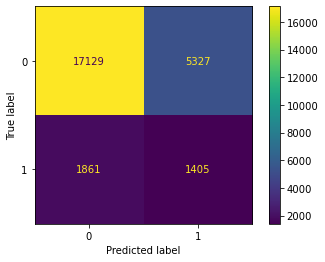

[[17129  5327]
 [ 1861  1405]]


In [84]:
# run the model with max validation auc, negative accuracy and smaller number of variables

xgbc = XGBClassifier(n_estimators=15, learning_rate=0.2, max_depth = 8)
xgbc.fit(X_train[features], y_train)

scores = cross_val_score(xgbc, X_train[features], y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
 
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train[features], y_train, cv=kfold)
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

ypred = xgbc.predict(X_test[features])
cm = confusion_matrix(y_test,ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=xgbc.classes_)
disp.plot()

plt.show()
print(cm)



In [85]:
#Get X variables
X_holdout = df_holdout_final[features]
#Get all 6 target variables
y1_var, y2_var, y3_var, y4_var, y5_var, y6_var = df_holdout_final[target_vars].columns
y_vars = [y1_var, y2_var, y3_var, y4_var, y5_var, y6_var]
ys_holdout = {var:df_holdout_final[var] for var in y_vars}

In [86]:
y_holdout = ys_holdout[y5_var]
y_holdout

0         0
2         1
3         0
4         0
5         0
         ..
187769    0
187770    0
187772    0
187773    0
187774    0
Name: THREE_PLUS_EVER_9M, Length: 57188, dtype: int64

In [87]:
Counter(y_holdout)

Counter({0: 50869, 1: 6319})

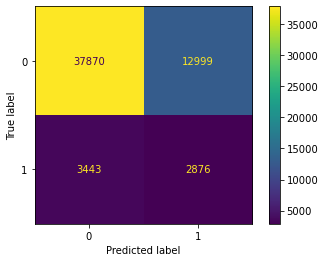

[[37870 12999]
 [ 3443  2876]]
0.7444612632448053
0.4551353062193385


In [88]:
ypred = xgbc.predict(X_holdout)
cm = confusion_matrix(y_holdout,ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=xgbc.classes_)
disp.plot()

plt.show()
pos_accuracy = cm[0,0] / (cm[0,0] + cm[0,1])
neg_accuracy = cm[1,1] / (cm[1,1] + cm[1,0])
print(cm)
print(pos_accuracy)
print(neg_accuracy)

In [89]:
accuracy_score(y_holdout,ypred)

0.7124921312163391

In [90]:
f1_score(y_holdout,ypred)

0.2591691448139136

In [91]:
y_pred_probs_val = xgbc.predict_proba(X_test[features])[:,1]
auc_val = round(roc_auc_score(y_test, y_pred_probs_val), 3)
auc_val

0.657

In [92]:
pd.DataFrame(y_pred_probs_val).to_excel('xgb_final_prob.xlsx',index=False)

In [93]:
y_test.to_excel('xgb_final_ytest.xlsx',index=False)

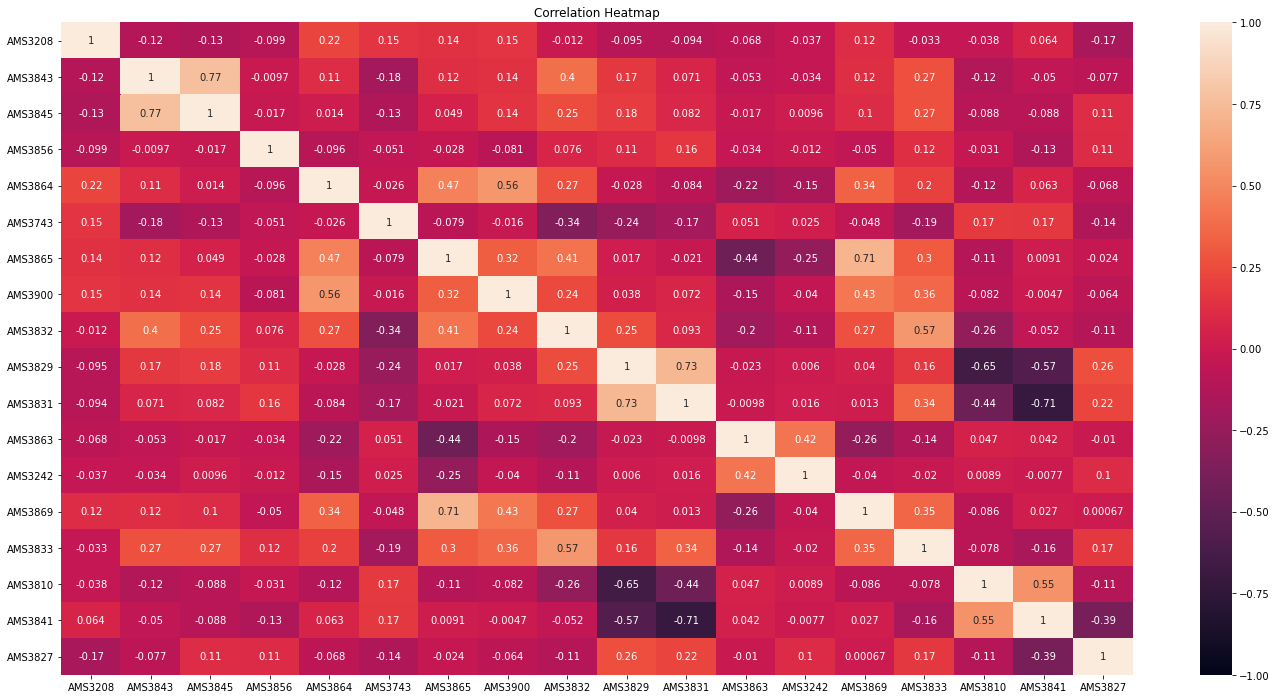

In [94]:
corr_df = X_test[features].corr()
fig, ax = plt.subplots(figsize=(24, 12))
sns.heatmap(corr_df, annot=True, vmin=-1.0)
plt.title('Correlation Heatmap')
plt.show()

In [95]:
final_features_df = df_column_map[df_column_map['original_cname'].isin(features)]
final_features_df

,original_cname,mapped_cname
101,AMS3208,T High Credit Open Rev Trades w/Update w/in 3 M
115,AMS3242,T PD Inst Trades
327,AMS3743,M on File
363,AMS3810,% Retail Trades to Rev Trades
371,AMS3827,% Inst Trades to Trades
373,AMS3829,% Bkcrd Trades to Rev Trades
375,AMS3831,% Open Bkcrd Trades to Open Rev Trades
376,AMS3832,% Open Trades to Trades
377,AMS3833,% Open Bkcrd Trades to Bkcrd Trades
385,AMS3841,% Open Retail Trades to Open Trades


In [96]:
final_features_df.to_excel('xgb_final_features.xlsx',index=False)